                                                                                                      Lorenzo Sutera 793519
# Progetto: Abalone Data Set

**Descrizione problema:**
Predire l'età di un abalone date le sue misure fisiche. L'età di un abalore si determina tagliando il guscio attraverso il cono, tingendolo(qualche tipo di inchiostro), e contando il numero di anelli attravero un microscopio -- un procedimento lungo e noioso. Le altre misure, che sono più semprlici da ottenere, sono utilizzate peer predire l'età. Ulteriori informazioni come luogo e il condizioni meteo del luogo in cui sono stati trovati possono essere un aiuto per la risoluzione di questo problema.

Il numero di anelli è ciò che si deve predire: si può scegliere di fare sia come valore continuo che classificazione.

- Dati provenienti da uno studio(non-machine-learning) originale.
- Number of Instances: 4177
- Number of Attributes: 8

**Informazioni sugli attributi:**

Nome / Tipo / Unità di misura / Descrizione

- Sex / nominal / -- / M, F, e I (infante) (sesso)
- Length / continuous / mm / misura più lunga del guscio (lunghezza)
- Diameter	/ continuous / mm / perpendicolare alla lunghezza (diametro)
- Height / continuous / mm / con l'animale nel guscio (altezza)
- Whole weight / continuous / grams / Abalone intero (peso completo)
- Shucked weight / continuous	/ grams / peso del'animale (peso parziale) 
- Viscera weight / continuous / grams / senza sangue (peso delle interiora) 
- Shell weight / continuous / grams / dopo la sgusciatura (peso del solo guscio) 
- Rings / integer / -- / numero di anelli + 1.5 si ottiene l'età

Informazioni utili sulla variabile da predire sono che gli abaloni in genere arrivano ad avere fino a un massimo di 30 anelli( come vedremo, in questo dataset 29).
Osservando gli attributi messi a disposizione, e considerando le cose sopra citate, la  predizione del numero di anelli può essere vista come regressione o come classificazione con più di 2 classi(multiclasse).
**Continuerò questo progetto considerando il caso della classificazione.**

Come classi, quindi, prenderò in considerazione 8 sotto insiemi disgiunti dei valori che rings può assumere(1->30).
Questo perchè con un numero troppo elevato di classi il tempo impiegato per eseguire il codice diventa troppo lungo.

Osservando i dati notiamo che i pesi hanno una relazione tra loro, cioè il peso totale di un abalone è circa la somma di tutti gli altri pesi + il peso del sangue che è stato rimosso(valore mancante nelle feature ma ricavabile).

Dati presi dalle medie della tabella df.describe():

	shuked_weight + viscera_weight + shell_weight ≅ whole_weight 
    0.359367      + 0.180594	   + 0.238831     ≅ 0.828742(=0,78)


In [1]:
#togliere il commento per non visualizzare i future warnings
#from warnings import filterwarnings
#filterwarnings('ignore')
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.exceptions import ConvergenceWarning
#warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

-------------
## Importiamo il dataset nel progetto

In [2]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = []
with open("abalone.data", "r") as f:
    reader = csv.reader(f, delimiter=",")
    for riga in reader:
        data.append(riga)
#data

Modifichiamo il tipo di sex in modo da ottimizare la memoria utilizzata.(ho verificato che uint8 utilizza meno memori a di category)

In [4]:
sexnum = []
for row in data:
    if row[0]=='I':
        sexnum.append(0)
    if row[0]=='M':
        sexnum.append(1)
    if row[0]=='F':
        sexnum.append(2)

Per ottimizare ulteriormente l'utilizzo della memoria possiamo utilizare uint8 anche per la variabile rings la quale non supera mai il valore 29 e che quindi rientra in un unsigned int di 8 bit.
Le altre valiabili sono tutte con la virgola.

In [5]:
df = pd.DataFrame(data, columns=['sex', 'length', 'diameter', 'height', 'whole_weight', 'shuked_weight', 'viscera_weight', 'shell_weight', 'rings'])
df['sex'] = sexnum
df = df.astype(dtype= {"sex":"uint8","length":"float64","diameter":"float64","height":"float64","whole_weight":"float64","shuked_weight":"float64","viscera_weight":"float64","shell_weight":"float64","rings":"uint8"})
#df.info()

**Analiziamo i dati mediante i grafici e tabelle.**

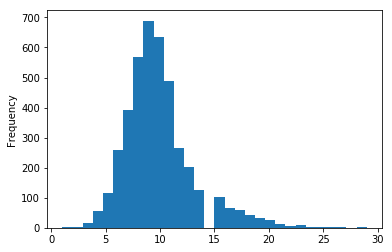

In [6]:
df["rings"].plot.hist(30)

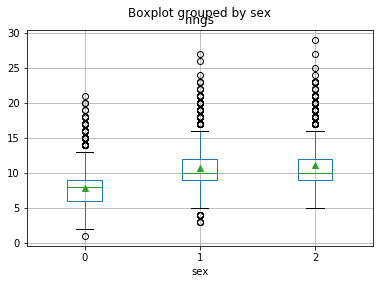

In [7]:
df.boxplot(column="rings", by="sex",showmeans=True)

Possiamo notare che gli abaloni "I"(0) sono generalmente più piccoli(numero minore di anelli, e quindi di dimensioni come vedremo più giù) di quelli che sono già "M"(1) o "F"(2).

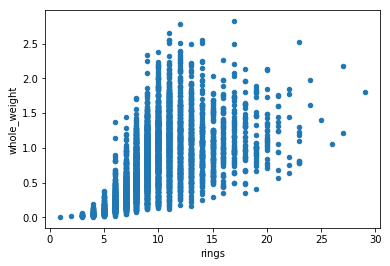

In [8]:
df.plot.scatter("rings","whole_weight")

Utiliziamo whole weight siccome possiamo considerare gli altri pesi proporzionali a questo.
Il grafico evidenzia che tendenzialmente gli anelli sono, come prevedibile, tanto più alti quanto lo è il peso completo, ma l'aumento è molto dispersivo nel grafico e forma un cono.  

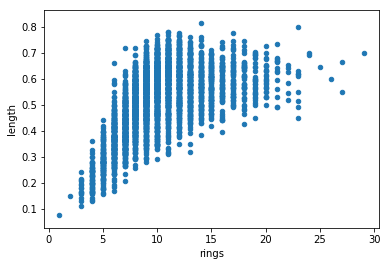

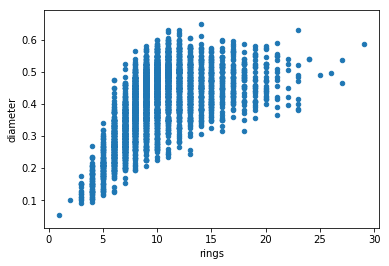

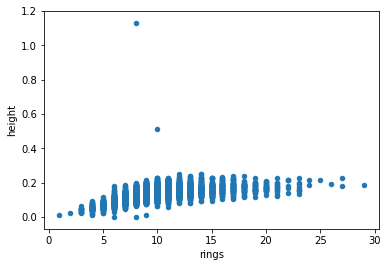

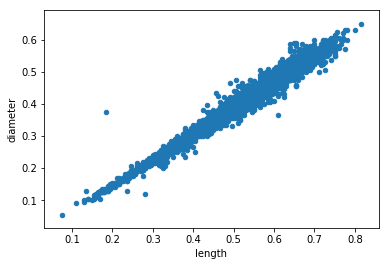

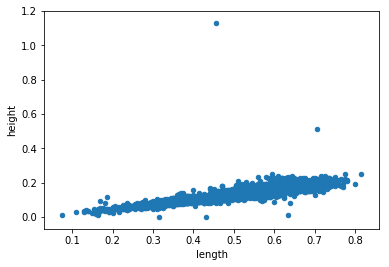

In [9]:
df.plot.scatter("rings","length")
df.plot.scatter("rings","diameter")
df.plot.scatter("rings","height")
df.plot.scatter("length","diameter")
df.plot.scatter("length","height")
df.plot.scatter("diameter","height")

- Osservando i primi 2 grafici possiamo vedere che sono molto simili tra loro e somigliano anche al grafico del peso complessivo.
- Il terzo grafico dimostra che l'altezza non ha un grande impatto sul numero di anelli di un abalone.
- Esaminando gli ultimi 3 grafici notiamo che lunghezza e diametro dono linearmente dipendenti tra loro e che questi ultimi hanno, quindi, la stessa relazione con l'altezza.

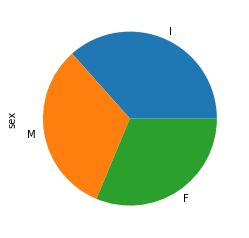

In [10]:
df["sex"].value_counts().plot.pie(labels=["I","M","F"])

La divisone di sex è molto equa.

In [11]:
df.describe()

sex       length     diameter       height  whole_weight  \
count  4177.000000  4177.000000  4177.000000  4177.000000   4177.000000   
mean      0.991621     0.523992     0.407881     0.139516      0.828742   
std       0.796410     0.120093     0.099240     0.041827      0.490389   
min       0.000000     0.075000     0.055000     0.000000      0.002000   
25%       0.000000     0.450000     0.350000     0.115000      0.441500   
50%       1.000000     0.545000     0.425000     0.140000      0.799500   
75%       2.000000     0.615000     0.480000     0.165000      1.153000   
max       2.000000     0.815000     0.650000     1.130000      2.825500   

       shuked_weight  viscera_weight  shell_weight        rings  
count    4177.000000     4177.000000   4177.000000  4177.000000  
mean        0.359367        0.180594      0.238831     9.933684  
std         0.221963        0.109614      0.139203     3.224169  
min         0.001000        0.000500      0.001500     1.000000  
25%         0.186000        0.093500      0.130000     8.000000  
50%         0.336000        0.171000      0.234000     9.000000  
75%         0.502000        0.253000      0.329000    11.000000  
max         1.488000        0.760000      1.005000    29.000000

Da questa tabella notiamo che **non ci sono valori mancanti** dato che count vale 4177 per tutte le feature e il dataset ha 4177 istanze.

Il valore medio degli anelli è quasi 10 che come possiamo notare corrisponde al picco più alto dell'istogramma mostrato sopra.
Possiamo anche notare che i percentili(25 50 75) hanno valori molto vicini in quanto su 29 possibili valori essi si trovino in un raggio di 4, il che avvalora il fatto che l'istogramma assume una forma gaussiana.

Lo scarto quadratico medio degli anelli si aggira intorno a 3.2 e indica di quanto i valori siano dispersi rispetto alla media.


## Divisione Classi
Guardando l'istogramma notiamo che prende una forma **gaussiana**, sono molto concentrati una piccola sezione. Per ridurre il tempo impiegato per eseguire il codice e fare dei test, riduciamo il numero di classi da 29 a 8. 
- 0 se     rings <= 4
- 1 se 4 < rings <= 8
- 2 se 8 < rings <= 10
- 3 se 10 < rings <= 13
- 4 se 13 < rings <= 16
- 5 se 16 < rings <= 20
- 6 se 20 < rings <= 24
- 7 se 24 < rings <= 30

**Sono stati scelti intervalli di divisione di grandezza diversa (anzi che utilizare pd.cut) perchè altrimenti nelle ultime classi ci sarebbero state meno istanze del numero di classi stesso, il che impedisce a SMOTE di operare.**

In [12]:
ring_c = []
for row in list(df["rings"]):
    if row<=4:
        ring_c.append(0)
    else:
        if row<=8:
            ring_c.append(1)
        else:
            if row<=10:
                ring_c.append(2)
            else:
                if row<=12:
                    ring_c.append(3)
                else:
                    if row<=15:
                        ring_c.append(4)
                    else:
                        if row<=19:
                            ring_c.append(5)
                        else:
                            if row<=23:
                                ring_c.append(6)
                            else:
                                if row<=30:
                                    ring_c.append(7)
df_class8 = df.copy(deep=True)
df_class8["rings"] = ring_c
df_class8["rings"].value_counts()

1    1333
2    1323
3     754
4     432
5     199
0      74
6      55
7       7
Name: rings, dtype: int64

- Le classi 6 e 7 sono troppo sbilanciate rispetto alle altre e impedirebbero l'applicazione di alcuni metodi come SMOTE oppure rendere la valutazione di un modello non corretta(la 7 classe potrebbe non finire mai un un train set o in un test set per esempio). Quindi decido di unirle in un'unica classe.

In [13]:
for i in range(0,len(df_class8["rings"])):
    if ring_c[i] == 7:
        ring_c[i] = 6
df_class8["rings"] = ring_c

In [14]:
df_class8["rings"].value_counts()

1    1333
2    1323
3     754
4     432
5     199
0      74
6      62
Name: rings, dtype: int64

- La divisione è leggermente migliore ma in questa maniera abbiamo perso tutta l'efficacia di classificare abaloni "più anziani"

In [15]:
#pd.cut(df["rings"], 8).value_counts().plot.pie()
plt.pie([sum(df_class8["rings"]==0), sum(df_class8["rings"]==1), sum(df_class8["rings"]==2), sum(df_class8["rings"]==3), sum(df_class8["rings"]==4), sum(df_class8["rings"]==5), sum(df_class8["rings"]==6)],labels=["minori di 4","compresi tra 4 e 8","compresi tra 8 e 10","compresi tra 10 e 12","compresi tra 12 e 15","compresi tra 15 e 19","compresi tra 19 e 30"])


([<matplotlib.patches.Wedge at 0x2b722ac2a58>,
 [Text(1.0982967246696975, 0.061190722988169736, 'minori di 4'),
  Text(0.485295922390223, 0.987161520578787, 'compresi tra 4 e 8'),
  Text(-1.0995022412217688, 0.03308808771004596, 'compresi tra 8 e 10'),
  Text(-0.04259674443147682, -1.0991749257346801, 'compresi tra 10 e 12'),
  Text(0.828782842578384, -0.7232696591505092, 'compresi tra 12 e 15'),
  Text(1.0677000652173418, -0.2646064449987641, 'compresi tra 15 e 19'),
  Text(1.0988042551816057, -0.05127581101061775, 'compresi tra 19 e 30')])

## Train set e Validation Set

- Divisione in train set e validation set 2/3 e 1/3

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    df_class8.drop(["rings"], axis=1),   #`X = tutto tranne rings
    df_class8["rings"],                  # y = rings
    test_size=0.3, random_state=42   # opzioni
)
#y_val.unique()

In [17]:
df8data = np.array(df_class8.drop(["rings"], axis=1))
df8target = np.array(df_class8["rings"])

----------------------------
--------------
------------
## Stratified K-Fold cross Validation
- **non è necessario implementarla perchè la grid search la applica internamente. il codice commentato seguente è come lo avevo fatto al'inizio.**

In [18]:
#from sklearn.model_selection import StratifiedKFold
#folds = StratifiedKFold(n_splits=3)
#scores_logistic = []
#scores_svm = []
#for train_index, test_index in folds.split(df8data,df8target):
#    X_train, X_test, y_train, y_test = df8data[train_index], df8data[test_index],df8target[train_index], df8target[test_index]
#    scores_logistic.append(get_score(LogisticRegression(solver='liblinear',multi_class='ovr'), X_train, X_test, y_train, y_test))  
#    scores_svm.append(get_score(SVC(gamma='auto'), X_train, X_test, y_train, y_test))

In [19]:
#scores_logistic
#np.array(scores_logistic).mean()

In [20]:
#scores_svm
#np.array(scores_svm).mean()

------
## Valutazione feature più rilevanti

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

**Percepron con penality l1** senza standardizzazione
- per vedere le feature più rilevanti

In [22]:
model = Pipeline([
    ("model",  Perceptron(penalty="l1", alpha=0.01))#0.0015 per vedere anche length
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.4688995215311005

In [23]:
X_train.columns[model.named_steps["model"].coef_[0] != 0]

Index(['whole_weight'], dtype='object')

- caso senza standardizzazione:
**length e wole_weight sono le feature più rilevanti secondo l1(whole_weight al primo posto)**.

 **Percepron con penality l1 e standardizzazione**
- per vedere le feature più rilevanti

In [24]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  Perceptron(penalty="l1", alpha=0.01))#0.005 per vedere anche length
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.43221690590111644

In [25]:
#model.named_steps['model'].coef_.T

In [26]:
X_train.columns[model.named_steps["model"].coef_[0] != 0]

Index(['length'], dtype='object')

- caso con standardizzazione:
**le feature length e diameter sono quelle più rilevanti secondo l1(length al primo posto)**.

------------------

## Valutazione distribuzione classi e pesi.

In [27]:
y_val.value_counts(normalize=True)

1    0.330941
2    0.321372
3    0.176236
4    0.094099
5    0.046252
0    0.017544
6    0.013557
Name: rings, dtype: float64

Data questa distribuzione faremo dei test con i pesi sulle classi(class_weight) e verificheremo se si ottiene un miglior risultato utilizzando i pesi o solo applicando SMOTE per "pareggiare" il numero di istanze per classe.

In [28]:
weights = {0:9, 1:0.4, 2:0.5, 3:1, 4:1.8, 5:3.6, 6:10}

## Installo imblearn per poter utilizzare SMOTE

In [29]:
pip install imblearn --user

Note: you may need to restart the kernel to use updated packages.


In [30]:
from imblearn.over_sampling import SMOTE
#y_train.value_counts()

In [31]:
smt = SMOTE()
X_train_s, y_train_s = smt.fit_sample(X_train, y_train)

In [32]:
np.bincount(y_train_s)

array([920, 920, 920, 920, 920, 920, 920], dtype=int64)

SMOTE ha creato nuovi elementi per le classi che ne avevano poche siccome erano sbilanciate.

------------------------------------
**Adesso proverò ad applicare modelli con tecniche diverse e valuterò quello che dà il risultato migliore:**
## Perceptron

- **senza pesi e senza SMOTE:**

In [33]:
model_p = Pipeline([
    ("scaler", StandardScaler()),
    ("perc",   Perceptron())
])

In [34]:
grid = {
    "scaler": [None, StandardScaler()],
    "perc__penalty": [None, "l1", "l2"],
    "perc__alpha": np.logspace(-3, 3, 7)
}

In [35]:
gs_p = GridSearchCV(model_p, grid, cv=3)

In [36]:
gs_p.fit(X_train, y_train)
gs_p.score(X_val, y_val)

C:\Users\Lorenzo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.3269537480063796

In [37]:
y_pred = gs_p.predict(X_val)
recall_score(y_val, y_pred,average=None)

array([0.        , 0.73493976, 0.01488834, 0.06334842, 0.72033898,
       0.        , 0.        ])

- Notiamo che ha 3 classi a 0

In [38]:
y_val_pred = gs_p.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)
cm

array([[  0,   6,   0,  16,   0,   0,   0],
       [  0, 305,   4,  66,  40,   0,   0],
       [  0, 146,   6,  37, 214,   0,   0],
       [  0,  39,   3,  14, 165,   0,   0],
       [  0,  19,   1,  13,  85,   0,   0],
       [  0,   3,   0,   3,  52,   0,   0],
       [  0,   0,   0,   1,  16,   0,   0]], dtype=int64)

- **Con i pesi:**

In [39]:
model_p = Pipeline([
    ("scaler", StandardScaler()),
    ("perc",   Perceptron(class_weight=weights))
])

In [40]:
grid = {
    "scaler": [None, StandardScaler()],
    "perc__penalty": [None, "l1", "l2"],
    "perc__alpha": np.logspace(-3, 3, 7)#,
    #"perc__class_weight" : [None,weights]
}

In [41]:
gs_p = GridSearchCV(model_p, grid)

In [42]:
gs_p.fit(X_train, y_train)
gs_p.score(X_val, y_val)

C:\Users\Lorenzo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.21052631578947367

In [43]:
y_pred = gs_p.predict(X_val)
recall_score(y_val, y_pred,average=None)

array([0.40909091, 0.57349398, 0.        , 0.        , 0.        ,
       0.        , 1.        ])

- Notiamo che ha 3 classi a 0

In [44]:
y_val_pred = gs_p.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)
cm

array([[  9,  13,   0,   0,   0,   0,   0],
       [  4, 238,   0,   0,   0,   0, 173],
       [  0,  38,   0,   0,   0,   0, 365],
       [  0,   9,   0,   0,   0,   0, 212],
       [  0,   4,   0,   0,   0,   0, 114],
       [  0,   2,   0,   0,   0,   0,  56],
       [  0,   0,   0,   0,   0,   0,  17]], dtype=int64)

- **con SMOTE:**

In [45]:
model_p = Pipeline([
    ("scaler", StandardScaler()),
    ("perc",   Perceptron())
])

In [46]:
grid = {
    "scaler": [None, StandardScaler()],
    "perc__penalty": [None, "l1", "l2"],
    "perc__alpha": np.logspace(-3, 3, 7)
}

In [47]:
gs_p = GridSearchCV(model_p, grid)

In [48]:
gs_p.fit(X_train_s, y_train_s)
gs_p.score(X_val, y_val)

C:\Users\Lorenzo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.266347687400319

In [49]:
y_pred = gs_p.predict(X_val)
recall_score(y_val, y_pred,average=None)

array([0.81818182, 0.13012048, 0.32009926, 0.4479638 , 0.00847458,
       0.44827586, 0.41176471])

- Notiamo che ha 2 classi a 0

In [50]:
y_val_pred = gs_p.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)
cm

array([[ 18,   0,   2,   0,   2,   0,   0],
       [ 22,  54, 253,  18,  39,  27,   2],
       [  0,  62, 129, 127,   3,  76,   6],
       [  0,  14,  38,  99,   0,  60,  10],
       [  0,   1,  12,  33,   1,  54,  17],
       [  0,   1,   2,  11,   0,  26,  18],
       [  0,   0,   0,   1,   0,   9,   7]], dtype=int64)

## Il risultato migliore lo da SMOTE!
- Quindi continueremo ad utilizzarlo anche per i test dei modelli successivi.

In [51]:
pd.DataFrame(gs_p.cv_results_).sort_values("rank_test_score").head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
25       0.026015      0.000814         0.001000    1.123916e-07   
1        0.023666      0.002055         0.000667    4.713704e-04   
31       0.028000      0.004321         0.001002    2.433998e-06   
19       0.025335      0.000470         0.000998    2.755314e-06   
7        0.023669      0.002093         0.001015    2.051170e-05   

   param_perc__alpha param_perc__penalty  \
25                10                None   
1              0.001                None   
31               100                None   
19                 1                None   
7               0.01                None   

                                         param_scaler  \
25  StandardScaler(copy=True, with_mean=True, with...   
1   StandardScaler(copy=True, with_mean=True, with...   
31  StandardScaler(copy=True, with_mean=True, with...   
19  StandardScaler(copy=True, with_mean=True, with...   
7   StandardScaler(copy=True, with_mean=True, with...   

                                               params  split0_test_score  \
25  {'perc__alpha': 10.0, 'perc__penalty': None, '...           0.366217   
1   {'perc__alpha': 0.001, 'perc__penalty': None, ...           0.366217   
31  {'perc__alpha': 100.0, 'perc__penalty': None, ...           0.366217   
19  {'perc__alpha': 1.0, 'perc__penalty': None, 's...           0.366217   
7   {'perc__alpha': 0.01, 'perc__penalty': None, '...           0.366217   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
25           0.444858           0.409897         0.406988        0.032188   
1            0.444858           0.409897         0.406988        0.032188   
31           0.444858           0.409897         0.406988        0.032188   
19           0.444858           0.409897         0.406988        0.032188   
7            0.444858           0.409897         0.406988        0.032188   

    rank_test_score  
25                1  
1                 1  
31                1  
19                1  
7                 1

--------------------------------
## Regessione Logistica

In [52]:
from sklearn.linear_model import LogisticRegression

- **con i pesi:**

In [53]:
model_rl = Pipeline([
    ("scaler", StandardScaler()),
    ("lr",     LogisticRegression(class_weight=weights))#max_iter=200 per risolvere il ConvergenceWarning ma rallenta troppo l'elaborazione e da lo stesso score.
])
grid = {
    "scaler": [None, StandardScaler()],
    #"lr__multi_class": ['auto','ovr'],
    "lr__penalty": ["l2", "l1"],
    "lr__C": np.logspace(-3, 3, 7)
}
gs_lr = GridSearchCV(model_rl, grid)

In [54]:
gs_lr.fit(X_train, y_train)
gs_lr.score(X_val, y_val)

0.48484848484848486

In [55]:
y_pred = gs_p.predict(X_val)
recall_score(y_val, y_pred,average=None)

array([0.81818182, 0.13012048, 0.32009926, 0.4479638 , 0.00847458,
       0.44827586, 0.41176471])

- **Con SMOTE senza pesi:**

In [56]:
model_rl = Pipeline([
    ("scaler", StandardScaler()),
    ("lr",     LogisticRegression())#max_iter=200 per risolvere il ConvergenceWarning ma rallenta troppo l'elaborazione e da lo stesso score.
])
grid = {
    "scaler": [None, StandardScaler()],
    #"lr__multi_class": ['auto','ovr'],
    "lr__penalty": ["l2", "l1"],
    "lr__C": np.logspace(-3, 3, 7)
}
gs_lr = GridSearchCV(model_rl, grid)

In [57]:
gs_lr.fit(X_train_s, y_train_s)
gs_lr.score(X_val, y_val)

0.45773524720893144

In [58]:
y_pred = gs_p.predict(X_val)
recall_score(y_val, y_pred,average=None)

array([0.81818182, 0.13012048, 0.32009926, 0.4479638 , 0.00847458,
       0.44827586, 0.41176471])

- **senza pesi e senza SMOTE:**

In [59]:
gs_lr.fit(X_train, y_train)
gs_lr.score(X_val, y_val)

0.5279106858054227

In [60]:
y_pred = gs_p.predict(X_val)
recall_score(y_val, y_pred,average=None)

array([0.81818182, 0.13012048, 0.32009926, 0.4479638 , 0.00847458,
       0.44827586, 0.41176471])

**Tutti i modelli lasciano la recall di 3 feature a 0**

In [61]:
pd.DataFrame(gs_lr.cv_results_).sort_values("rank_test_score").head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_lr__C  \
27       0.975008      0.243437         0.001984        0.000024        1000   
26       1.163691      0.131072         0.001649        0.000460        1000   
23       0.786715      0.220580         0.001963        0.000027         100   
25       0.034000      0.000817         0.001333        0.000472        1000   
22       1.200691      0.081845         0.001964        0.000025         100   

   param_lr__penalty                                       param_scaler  \
27                l1  StandardScaler(copy=True, with_mean=True, with...   
26                l1                                               None   
23                l1  StandardScaler(copy=True, with_mean=True, with...   
25                l2  StandardScaler(copy=True, with_mean=True, with...   
22                l1                                               None   

                                               params  split0_test_score  \
27  {'lr__C': 1000.0, 'lr__penalty': 'l1', 'scaler...           0.517418   
26  {'lr__C': 1000.0, 'lr__penalty': 'l1', 'scaler...           0.517418   
23  {'lr__C': 100.0, 'lr__penalty': 'l1', 'scaler'...           0.517418   
25  {'lr__C': 1000.0, 'lr__penalty': 'l2', 'scaler...           0.517418   
22  {'lr__C': 100.0, 'lr__penalty': 'l1', 'scaler'...           0.516393   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
27           0.525128           0.520576         0.521040        0.003167   
26           0.525128           0.520576         0.521040        0.003167   
23           0.523077           0.521605         0.520698        0.002399   
25           0.523077           0.520576         0.520356        0.002317   
22           0.525128           0.519547         0.520356        0.003613   

    rank_test_score  
27                1  
26                1  
23                3  
25                4  
22                4

----------------------------
questo modello è quello che ha dato il miglior risultato (score>0.56) di tutti ma l'ho trovato senza un vero e proprio metodo, per ricavarlo dovrei inserire nella grid search anche il calcolo della polynomialFeature però, in quel caso, l'elaborazione diventerebbe esageratamente lunga. Dato che non è un risultato che ho ricavato con metodo, non lo analizzerò.

from sklearn.preprocessing import PolynomialFeatures
model_rl_std_pol = Pipeline([
 ("scaler", StandardScaler()),
 ("poly", PolynomialFeatures(degree=2)),
 ("logreg", LogisticRegression(C=50))
])

model_rl_std_pol.fit(X_train, y_train)
model_rl_std_pol.score(X_val, y_val)

#model_rl_std_pol.named_steps['logreg'].coef_.T

----------------------------

------------------------
## Support Vector Machines

In [62]:
from sklearn.svm import SVC 

- **Con pesi:**

In [63]:
model_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm",  SVC(class_weight=weights))
])
grid = {
    "scaler": [None, StandardScaler()],
    "svm__kernel": ["linear", "rbf"]
}
gs_svm = GridSearchCV(model_svm, grid)

In [64]:
gs_svm.fit(X_train_s, y_train_s)
gs_svm.score(X_val, y_val)

0.266347687400319

In [65]:
y_pred = gs_p.predict(X_val)
recall_score(y_val, y_pred,average=None)

array([0.81818182, 0.13012048, 0.32009926, 0.4479638 , 0.00847458,
       0.44827586, 0.41176471])

- **Con SMOTE:**

In [66]:
model_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm",  SVC())
])
grid = {
    "scaler": [None, StandardScaler()],
    "svm__kernel": ["linear", "rbf"]
}
gs_svm = GridSearchCV(model_svm, grid)

In [67]:
gs_svm.fit(X_train_s, y_train_s)
gs_svm.score(X_val, y_val)

0.46331738437001596

In [68]:
y_pred = gs_p.predict(X_val)
recall_score(y_val, y_pred,average=None)

array([0.81818182, 0.13012048, 0.32009926, 0.4479638 , 0.00847458,
       0.44827586, 0.41176471])

- **Senza pesi e senza SMOTE:**

In [69]:
model_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm",  SVC())
])
grid = {
    "scaler": [None, StandardScaler()],
    "svm__kernel": ["linear", "rbf"]
}
gs_svm = GridSearchCV(model_svm, grid)

In [70]:
gs_svm.fit(X_train, y_train)
gs_svm.score(X_val, y_val)

0.5502392344497608

In [71]:
y_pred = gs_p.predict(X_val)
recall_score(y_val, y_pred,average=None)

array([0.81818182, 0.13012048, 0.32009926, 0.4479638 , 0.00847458,
       0.44827586, 0.41176471])

In [72]:
pd.DataFrame(gs_svm.cv_results_).sort_values("rank_test_score").head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3       0.167647      0.002369         0.056017        0.000024   
2       0.183367      0.005314         0.033316        0.000449   
0       0.128982      0.003733         0.033367        0.000484   
1       0.157999      0.002471         0.059034        0.000025   

                                        param_scaler param_svm__kernel  \
3  StandardScaler(copy=True, with_mean=True, with...               rbf   
2  StandardScaler(copy=True, with_mean=True, with...            linear   
0                                               None            linear   
1                                               None               rbf   

                                              params  split0_test_score  \
3  {'scaler': StandardScaler(copy=True, with_mean...           0.534836   
2  {'scaler': StandardScaler(copy=True, with_mean...           0.512295   
0          {'scaler': None, 'svm__kernel': 'linear'}           0.485656   
1             {'scaler': None, 'svm__kernel': 'rbf'}           0.480533   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
3           0.525128           0.512346         0.524119        0.009208   
2           0.530256           0.517490         0.520014        0.007550   
0           0.485128           0.488683         0.486486        0.001565   
1           0.484103           0.486626         0.483750        0.002499   

   rank_test_score  
3                1  
2                2  
0                3  
1                4

-------------------------
- osserviamo la distribuzione delle classi normalizzate

In [73]:
y_val.value_counts(normalize=True)

1    0.330941
2    0.321372
3    0.176236
4    0.094099
5    0.046252
0    0.017544
6    0.013557
Name: rings, dtype: float64

Date le molte classi anche se non molto bilanciate, osserviamo che con un classificatore che predica sempre 1(classe più numerosa) otterrà un'accuratezza del 33,09% che è inferiore a quella del modello migliore che vedremo successivamente. Possiamo anche notare che le ultime 2 classi hanno un valore molto basso, il che influisce sul calcolo dei modelli.

-----------------
## Valutazione del miglir modello partendo dai 3 modelli migliori trovati sopra

    - Perceptron(Solo SMOTE):
    score:0.4226
    - Logistic Regression(Senza pesi e senza SMOTE):
    score:0.535
    - SVM(SVC)(Senza pesi e senza SMOTE)
    :score:0.5446

- I modelli con lo score più alto sono quelli che utilizzano Logistic Regression e SVM(SVC)

**Logistic Regression**:

In [74]:
y_val_pred = gs_lr.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)
#cm

In [75]:
classes = ['0','1', '2', '3', '4', '5', '6']
pd.DataFrame(cm, index=classes, columns=classes)

0    1    2   3   4  5  6
0  8   14    0   0   0  0  0
1  5  334   73   1   1  1  0
2  0  113  254  23  13  0  0
3  0   25  144  34  18  0  0
4  0    9   59  18  27  5  0
5  0    2   19  13  19  5  0
6  0    0    3   2  10  2  0

Ora calcoliamo **l'accuaratezza** prendendo la somma dei valori nella diagonale e dividendola per la somma complessiva:

In [76]:
n_lr = cm.sum()
accuratezza_lr = cm.diagonal().sum() / cm.sum()

Prendiamo una classe X di riferimento e calcoliamo la **precision** relativa a quella classe:

In [77]:
precision_score(y_val, y_val_pred, average=None)
#precision_val = []
#div_val = []
#for e in range(0,len(cm)):
#    precision_val.append(cm[e,e])
#    div_val.append(cm[:, e].sum())
#    precision_val[e] = precision_val[e] / div_val[e]
#precision_val        

C:\Users\Lorenzo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.61538462, 0.67203219, 0.46014493, 0.37362637, 0.30681818,
       0.38461538, 0.        ])

Prendiamo una classe X di riferimento e calcoliamo la **recall** relativa a quella classe:

In [78]:
recall_score(y_val, y_val_pred, average=None)
#recall_val = []
#divr_val = []
#for e in range(0,len(cm)):
#    recall_val.append(cm[e,e])
#    divr_val.append(cm[e, :].sum())
#    recall_val[e] = recall_val[e] / divr_val[e]
#recall_val

array([0.36363636, 0.80481928, 0.63027295, 0.15384615, 0.22881356,
       0.0862069 , 0.        ])

- **F1-measure**

Media armonica tra precision e recall:

In [79]:
f1_score(y_val, y_val_pred, average=None)
#F1_measure = []
#for e in range(0,len(cm)):
#    F1_measure.append(2 * precision_val[e] * recall_val[e] / (precision_val[e] + recall_val[e]))
#F1_measure

C:\Users\Lorenzo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.45714286, 0.73245614, 0.53193717, 0.21794872, 0.26213592,
       0.14084507, 0.        ])

----
**SVM(SVC)**:

In [80]:
y_val_pred = gs_svm.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)
#cm

In [81]:
classes = ['0','1', '2', '3', '4', '5', '6']
pd.DataFrame(cm, index=classes, columns=classes)

0    1    2   3   4  5  6
0  13    9    0   0   0  0  0
1   9  296  106   1   3  0  0
2   0   77  298  20   8  0  0
3   0   16  138  53  13  1  0
4   0    7   66  19  26  0  0
5   0    2   21  13  18  4  0
6   0    0    5   2   9  1  0

Notiamo che il modello migliore non assegna mai valori alle ultime 4 classi che sono proprio quelle con meno elementi all'interno. questo problema è dato dal fatto che il dataset originario non era ben equilibrato e assumeva una forma gaussiana. 

Ora calcoliamo **l'accuaratezza** sommando i valori nella diagonale e divisa per la somma complessiva:

In [82]:
n_svm = cm.sum()
accuratezza_svm =  cm.diagonal().sum() / cm.sum()

Prendiamo una classe X di riferimento e calcoliamo la **precision** relativa a quella classe:

In [83]:
precision_score(y_val, y_val_pred, average=None)
#precision_val = []
#div_val = []
#for e in range(0,len(cm)):
#    precision_val.append(cm[e,e])
#    div_val.append(cm[:, e].sum())
#    precision_val[e] = precision_val[e] / div_val[e]
#precision_val
        

C:\Users\Lorenzo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.59090909, 0.72727273, 0.47003155, 0.49074074, 0.33766234,
       0.66666667, 0.        ])

Prendiamo una classe X di riferimento e calcoliamo la **recall** relativa a quella classe:

In [84]:
recall_score(y_val, y_val_pred, average=None)
#recall_val = []
#divr_val = []
#for e in range(0,len(cm)):
#    recall_val.append(cm[e,e])
#    divr_val.append(cm[e, :].sum())
#    recall_val[e] = recall_val[e] / divr_val[e]
#recall_val

array([0.59090909, 0.71325301, 0.73945409, 0.239819  , 0.22033898,
       0.06896552, 0.        ])

- **F1-measure**

Media armonica tra precision e recall:

In [85]:
f1_score(y_val, y_val_pred, average=None)
#F1_measure = []
#for e in range(0,len(cm)):
#    F1_measure.append(2 * precision_val[e] * recall_val[e] / (precision_val[e] + recall_val[e]))
#F1_measure

C:\Users\Lorenzo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.59090909, 0.72019465, 0.57473481, 0.32218845, 0.26666667,
       0.125     , 0.        ])

## Caso in cui si usasse un modello casuale:
l'accuratezza sarebbe circa 1/numero classi quindi circa 0.142 che è molto inferiore a quello dei migliori modelli visti sopra.

## Confronto accuratezza dei 2 Modelli con confidenza 95%
- z = 1.96

In [86]:
e1 = 1- accuratezza_lr
e2 = 1- accuratezza_svm
d = abs(e1 - e2)
sigma = ((e1*(1-e1))/n_lr)+((e2*(1-e2))/n_svm)
#d+-1.96*sigma
dp=d-(1.96*sigma)
dg=d+(1.96*sigma)
print(dp, dg)

0.021552212005293465 0.02310488528338271


la differenza **è significativa** poiché l’intervallo [dp:dm] non contiene ZERO

## Valutazione dei risultati:

Confrontando il modello che usa Logistic Regression e quello che usa SVC vediamo che:
- L'accuratezza del secondo è migliore di quasi 0.1(0.544 - 0.535)
- Lo score nel secondo è migliore.
- La media delle recall nel secondo è maggiore del primo(0.3621536 > 0.3415749)
- Le F1-measure medie dei 2 modelli sono quasi uguali (lr=0.361 e svc=0.364)

Nonostante ciò il miglior modello **non** è quello con SVC:

Osservando i risultati delle confusion matrix scopriamo che nel modello con SVC la colonna della settima classe è tutta nulla, il che vuol dire che non è mai stato assegnato un abalone(tra quelli del test set) a quella classe, lo possiamo vedere anche dall'array della recall. Questo può voler dire che in questo modello viene completamente ignorata la settima classe, quindi:

Siccome la settima classe è quella che contiene l'intervallo di valori più grande(rings da 19 escluso a 29) in confronto alle altre (spesso grande più del doppio delle singole altre), nel caso in cui dovessi prevedere il numero di anelli di un abalone scelto casualmente, come modello sceglierei quello che fa uso della Logistic regession perchè abbiamo circa 1/3 (9 su 29) di probabilità che preso un abalone, in modo casuale, esso rientri nella settima classe, e se scegliessimo il modello SVC, non saremmo in grado di classificare nel modo corretto nessun abalone con più di 19 anelli.

Ora osserviamo quali feature sono più positivamente/negativamente correlate ed in che misura con la variabile da pre dire:

In [87]:
pd.Series(gs_lr.best_estimator_.named_steps["lr"].coef_[0], index=['sex', 'length', 'diameter', 'height', 'whole_weight', 'shuked_weight', 'viscera_weight', 'shell_weight'])

sex               -0.525020
length            25.020447
diameter         -38.244625
height            -7.804870
whole_weight       0.221262
shuked_weight      1.755535
viscera_weight   -89.352768
shell_weight     -71.763380
dtype: float64

Possiamo notare che più l'abalone è lungo più anelli il modello si aspetta di avere. Che è proprio come dicono i grafici all'inizio del documento.